# Exploration Lesson

### Goals:

- Can we see patterns, find signals in the data?

- What features are driving the outcome?

- Are there other features we can construct that have stronger relationships?

- Use visualization and statistical testing to help answer these questions.

- We want to walk away from exploration with with modeling strategies (feature selection, algorithm selection, evaluation methods).

### Scenario:

We would like to be able to use attributes of customers to estimate their spending score. In doing so, we can target those customers that are likely to be most profitable for us. Our target variable is spending_score. Currently the only customer data we have available to use in this project is age, annual_income and gender. It is possible we may not have enough information to build a valuable model. If not, maybe we could do some unsupervised learning, and find clusters of similar customers using all of the variables (including spending_score) and that could help us with a starting point for our targeted marketing.

In [1]:
#standard ds
import pandas as pd
import numpy as np

#viz and stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#splits, scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#my env file
from env import get_db_url

## Acquire!

In [2]:
df = pd.read_sql('SELECT * FROM customers;', get_db_url('mall_customers'))
df = df.set_index('customer_id')
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


## Prepare!

In [5]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe and splits the data into train, validate and test. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, random_state=seed)
    
    train, validate = train_test_split(train_validate, test_size=0.3, random_state=seed)
    return train, validate, test

In [7]:
def scale_my_data(train, validate, test):
    '''
    scale my data using minmaxscaler and add it back to my input datasets
    '''
    scaler = MinMaxScaler()
    scaler.fit(train[['age', 'annual_income']])
    
    X_train_scaled = scaler.transform(train[['age', 'annual_income']])
    X_validate_scaled = scaler.transform(validate[['age', 'annual_income']])
    X_test_scaled = scaler.transform(test[['age', 'annual_income']])

    train[['age_scaled', 'annual_income_scaled']] = X_train_scaled
    validate[['age_scaled', 'annual_income_scaled']] = X_validate_scaled
    test[['age_scaled', 'annual_income_scaled']] = X_test_scaled
    return train, validate, test

In [8]:
def prep_mall(df):
    '''
    dummy var for gender into is_male
    split on target of 'spending_score'
    scale age and annual income. 
    '''
    df['is_male'] = pd.get_dummies(df['gender'], drop_first=True)['Male']
    train, validate, test = train_validate_test_split(df, target='spending_score', seed=1349)
    train, validate, test = scale_my_data(train, validate, test)
    
    print(f'df: {df.shape}')
    print()
    print(f'train: {train.shape}')
    print(f'validate: {validate.shape}')
    print(f'test: {test.shape}')
    return df, train, validate, test

In [9]:
df, train, validate, test = prep_mall(df)

df: (200, 5)

train: (112, 7)
validate: (48, 7)
test: (40, 7)


In [10]:
train.head()

,gender,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled
customer_id,,,,,,,
27,Female,45,28,32,0,0.519231,0.106557
24,Male,31,25,73,1,0.250000,0.081967
40,Female,20,37,75,0,0.038462,0.180328
38,Female,30,34,73,0,0.230769,0.155738
57,Female,51,44,50,0,0.634615,0.237705


## Explore!

1. Ask your question

2. Vizualize it

3. Perform a stats test, if needed

4. Write your takeaway

### Q1. What is the distribution of each variable?

Since I'm doing at univariate exploration, I can use the original dataset.

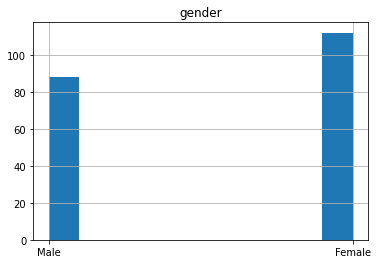

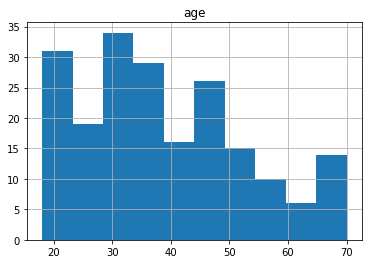

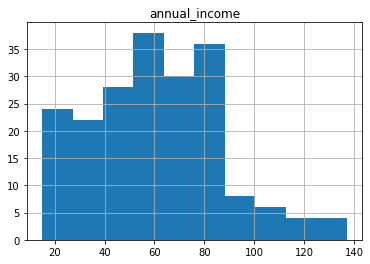

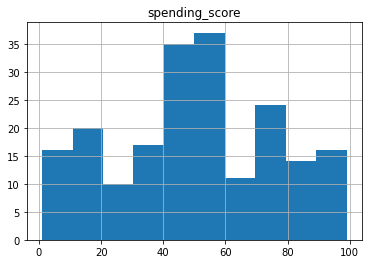

In [14]:
for col in df.columns[:-1]:
    df[col].hist()
    plt.title(col)
    plt.show()

#### Takeaways

- slight inbalance in gender
- age and annual_income is right skewed
- spending_score is normally distribution

Note: I care about distributions for the stats test

### Q2. Does the spending score differ across gender?

In [16]:
train.head()

,gender,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled
customer_id,,,,,,,
27,Female,45,28,32,0,0.519231,0.106557
24,Male,31,25,73,1,0.250000,0.081967
40,Female,20,37,75,0,0.038462,0.180328
38,Female,30,34,73,0,0.230769,0.155738
57,Female,51,44,50,0,0.634615,0.237705


I am now comparing variables, so I HAVE to use the train dataset.

> what type of variable is spending_score? continuous  
> what type of variable is gender? categorical

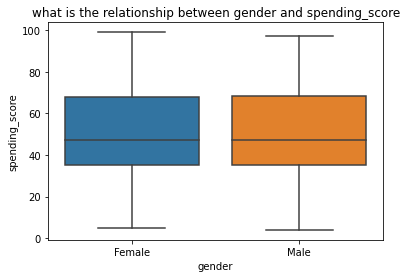

In [18]:
sns.boxplot(data=train, x='gender', y='spending_score')
plt.title('what is the relationship between gender and spending_score')
plt.show()

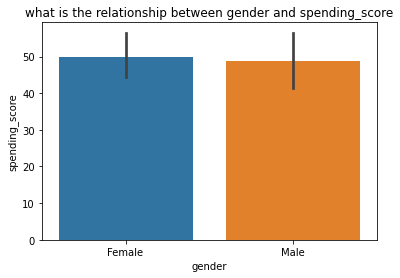

In [19]:
sns.barplot(data=train, x='gender', y='spending_score')
plt.title('what is the relationship between gender and spending_score')
plt.show()

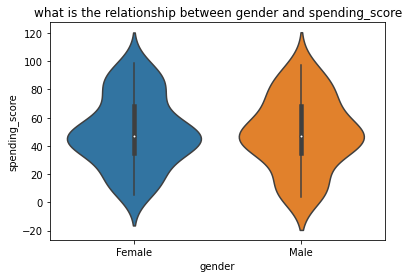

In [20]:
sns.violinplot(data=train, x='gender', y='spending_score')
plt.title('what is the relationship between gender and spending_score')
plt.show()

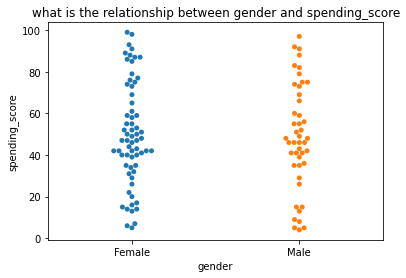

In [21]:
sns.swarmplot(data=train, x='gender', y='spending_score')
plt.title('what is the relationship between gender and spending_score')
plt.show()

Thoughts

- it looks like gender does not affect our spending score

Which stats test to use? 

- we have continuous and categorical variables, so we will do a comparing means test
- since they are normally distributed, we can use a t-test
- we have 2 independent categories, therefore, we will use a 2-sample t-test
- since we are checking to see if they are the same, we will use a 2-tail t-test

Note: when using a t-test, we have to check for equal variances

Levene Test
- Ho: the variances are equal
- Ha: the variances are different

alpha = 0.05

In [24]:
#stats.levene()
stats.levene(train.spending_score[train.gender=='Male'],
            train.spending_score[train.gender=='Female'])

LeveneResult(statistic=0.016334996444000886, pvalue=0.8985339363273774)

> we have a high pvalue, therefore, we fail to reject the null hypothesis

2-sample, 2-tail t-test

In [26]:
#stats.ttest_ind()
stats.ttest_ind(train[train.gender=='Male'].spending_score, 
                train[train.gender=='Female'].spending_score,
               equal_var=True)

Ttest_indResult(statistic=-0.2520372896728062, pvalue=0.8014825487089098)

> the pvalue is high, therefore, we fail to reject to null hypothesis

#### Takeaway

- there is not a significant difference in spending score means between gender

### Q3. Is there a relationship between spending score and annual income?

> what type of variable is spending score? continuous, target   
> what type of variable is annual income? continuous

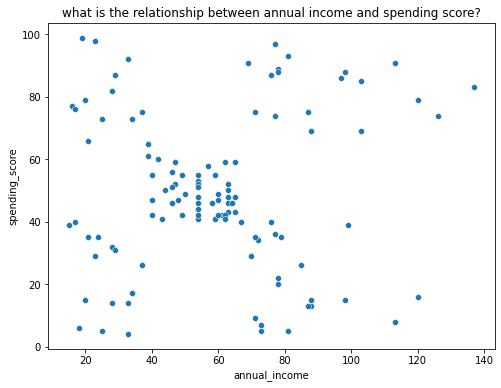

In [30]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=train, x='annual_income', y='spending_score')
plt.title('what is the relationship between annual income and spending score?')
plt.show()

Thoughts

- there does not appear to be a linear relationship
- it looks like a big X
- these could be clusters!

Which stats test to use? 


- we have two continuous variables, therefore, we will do a correlation test 
- since they are not normally distributed, we will use spearmans test

Spearmean R


- Ho: there is no linear correlation between annual income and spending score
- Ha: there is linear correlation between annual income and spending score

In [32]:
#stats.spearmanr()
stats.spearmanr(train.annual_income, train.spending_score)

SpearmanrResult(correlation=0.0139166413882597, pvalue=0.8842097894086705)

> our pvalue is very high, so we fail to reject the null hypothesis

#### Takeaways

- there is no linear correlation between annual income and spending score
- however, there does appear to be some kind of non-linear relationship

### Q4. Is there a relationship between age and spending score? 

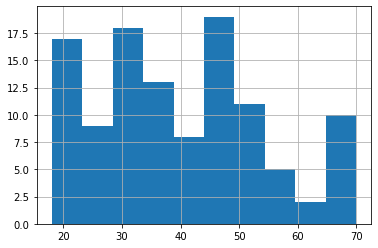

In [34]:
train.age.hist()
plt.show()

In [35]:
train.age.nunique()

46

> what type of variable is age? continuous     
> what type of variable is spending score? continuous 

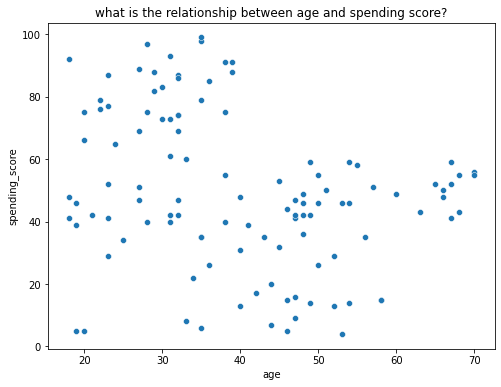

In [37]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=train, x='age', y='spending_score', )
plt.title('what is the relationship between age and spending score?')
plt.show()

Thoughts
- there doesnt really look like a linear relationship
- at 40 years old, something is happening, there is a dropoff in spending score

We'll use `pd.cut()` to make bins

In [66]:
#make new age_bin column
#adding a label is helpful for calling that column!
train['age_bins'] = pd.cut(train.age,[0,40,80], labels=['40_and_under', 'over_40'])

In [67]:
train.head()

,gender,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled,age_bins
customer_id,,,,,,,,
27,Female,45,28,32,0,0.519231,0.106557,over_40
24,Male,31,25,73,1,0.250000,0.081967,40_and_under
40,Female,20,37,75,0,0.038462,0.180328,40_and_under
38,Female,30,34,73,0,0.230769,0.155738,40_and_under
57,Female,51,44,50,0,0.634615,0.237705,over_40


In [68]:
train.age_bins.value_counts()

40_and_under    62
over_40         50
Name: age_bins, dtype: int64

In [69]:
train.dtypes

gender                    object
age                        int64
annual_income              int64
spending_score             int64
is_male                    uint8
age_scaled               float64
annual_income_scaled     float64
age_bins                category
dtype: object

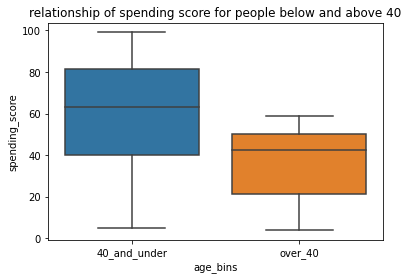

In [70]:
sns.boxplot(data=train, x='age_bins', y='spending_score')
plt.title('relationship of spending score for people below and above 40')
plt.show()

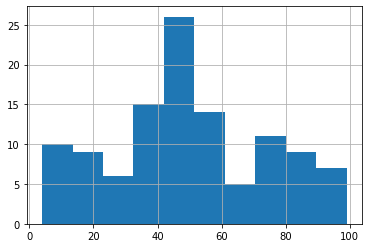

In [71]:
train.spending_score.hist()
plt.show()

Which stats test to use? 


- 2-sample, 2-tail, t-test

note: when using a ttest, have to test for equal variances! 

Levene test

In [72]:
#stats.levene
stats.levene(train.spending_score[train.age_bins == '40_and_under'],
             train.spending_score[train.age_bins == 'over_40'],)

LeveneResult(statistic=15.352912166943206, pvalue=0.00015525914569012802)

> our pvalue is less than alpha, therefore we reject the null hypothesis  
> our variances are not equal

In [73]:
#stats.ttest_ind
stats.ttest_ind(train.spending_score[train.age_bins == '40_and_under'],
             train.spending_score[train.age_bins == 'over_40'],
               equal_var=False)

Ttest_indResult(statistic=5.292725484839427, pvalue=6.652618486151613e-07)

> our pvalue is less than alpha, therefore we reject the null hypothesis

#### Takeaway

- There is a difference in spending for people over 40 and people under 40. 

### Q. If we control for age, does spending score differ across annual income?

Use `sns.relplot` to control for variables

In [81]:
train.spending_score.mean()

49.473214285714285

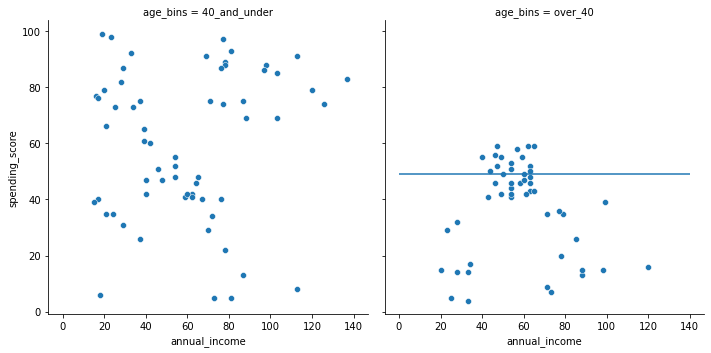

In [84]:
sns.relplot(data=train, x='annual_income', y='spending_score', 
#             hue='age_bins',
            col='age_bins'
           )
plt.hlines(49, 0, 140)
plt.show()

Thoughts


- we see more customers with a high spending score for customers over 40
- we see half an X in the customers over 40
- customers over 40 dont have high spending scores

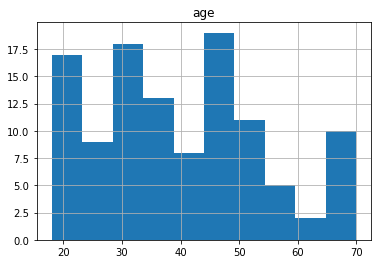

In [87]:
train.age.hist()
plt.title('age')
plt.show()

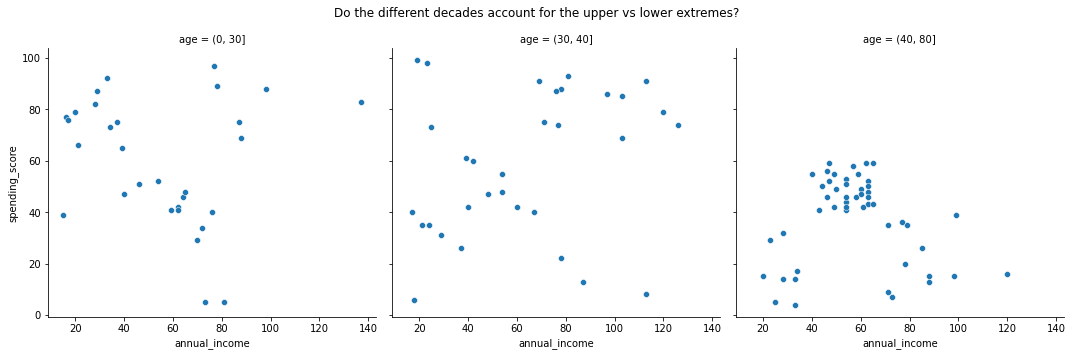

In [92]:
#create age bins in col

sns.relplot(data=train, x='annual_income', y='spending_score', 
#             hue='age_bins',
            col=pd.cut(train.age,[0,30,40,80])
           )

plt.suptitle("Do the different decades account for the upper vs lower extremes?")
plt.tight_layout()
plt.show()

Thoughts

- starting to see a negative linear relationship in customers less than 30
- customers betweeen 30 and 40 are still scattered everywhere
- over 40 customers still have the half X shape

#### Does gender play a role?

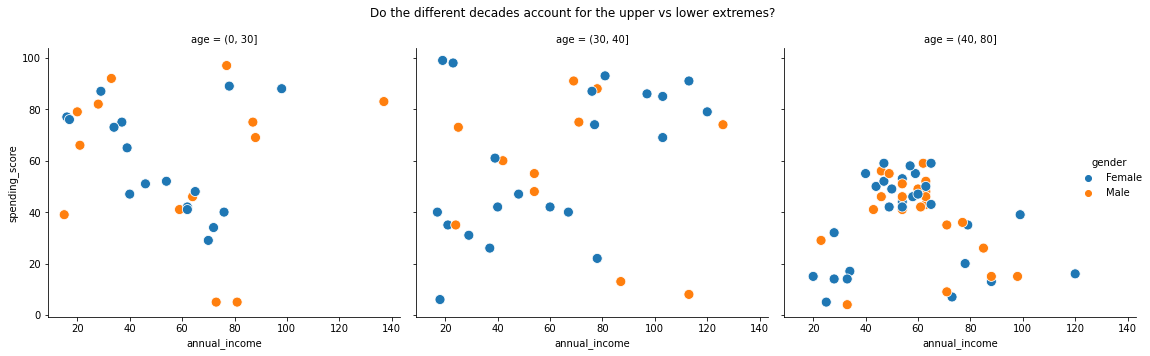

In [95]:
sns.relplot(data=train, x='annual_income', y='spending_score', 
            hue='gender',
            s=100,
            col=pd.cut(train.age,[0,30,40,80])
           )

plt.suptitle("Do the different decades account for the upper vs lower extremes?")
plt.tight_layout()
plt.show()

Thoughts


- gender still doesn't tell us anything

#### Takeaways


- spending score and income does change with age, especially at the 40 year mark
- also, gender does not affect these variables

### Q. If we control for annual income, does spending score differ across age?

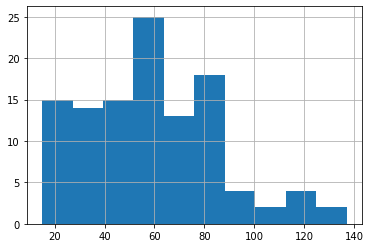

In [97]:
train.annual_income.hist()
plt.show()

In [100]:
train['income_bins'] = pd.cut(train.annual_income, [0,50,140])

In [101]:
train.head()

,gender,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled,age_bins,income_bins
customer_id,,,,,,,,,
27,Female,45,28,32,0,0.519231,0.106557,over_40,"(0, 50]"
24,Male,31,25,73,1,0.250000,0.081967,40_and_under,"(0, 50]"
40,Female,20,37,75,0,0.038462,0.180328,40_and_under,"(0, 50]"
38,Female,30,34,73,0,0.230769,0.155738,40_and_under,"(0, 50]"
57,Female,51,44,50,0,0.634615,0.237705,over_40,"(0, 50]"


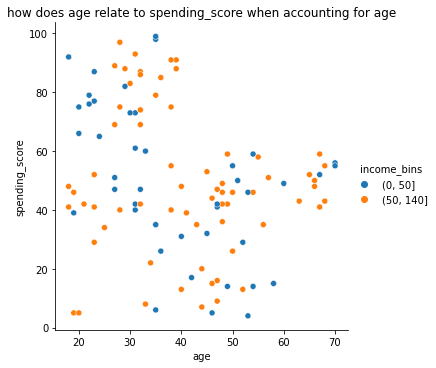

In [108]:
sns.relplot(data=train, x='age', y='spending_score',
           hue='income_bins'
           )


plt.title('how does age relate to spending_score when accounting for age')
plt.show()

Takeaways


- when accounting for income, the relationships do not seem to change

In [109]:
df.head()

,gender,age,annual_income,spending_score,is_male
customer_id,,,,,
1,Male,19,15,39,1
2,Male,21,15,81,1
3,Female,20,16,6,0
4,Female,23,16,77,0
5,Female,31,17,40,0


### If you don't know where to start, start with pairplot

In [112]:
train.columns

Index(['gender', 'age', 'annual_income', 'spending_score', 'is_male',
       'age_scaled', 'annual_income_scaled', 'age_bins', 'income_bins'],
      dtype='object')

Interaction of variables along with income bins


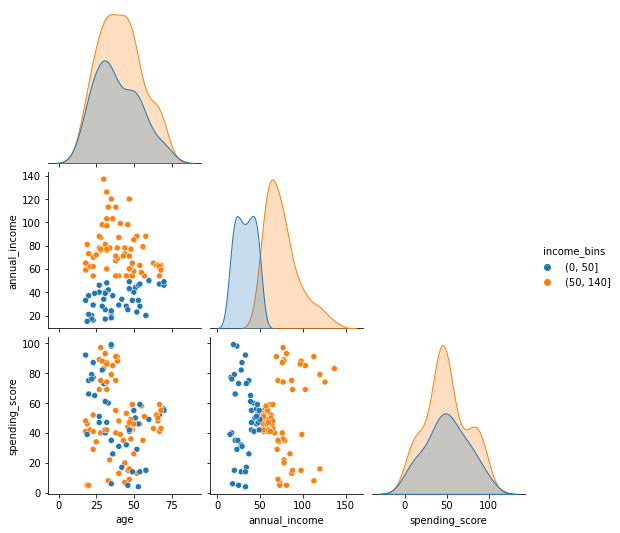

In [116]:
print("Interaction of variables along with income bins")
sns.pairplot(train[['gender', 'age', 'annual_income', 'spending_score', 'income_bins']], 
             corner=True,
             hue='income_bins'
            )
plt.show()

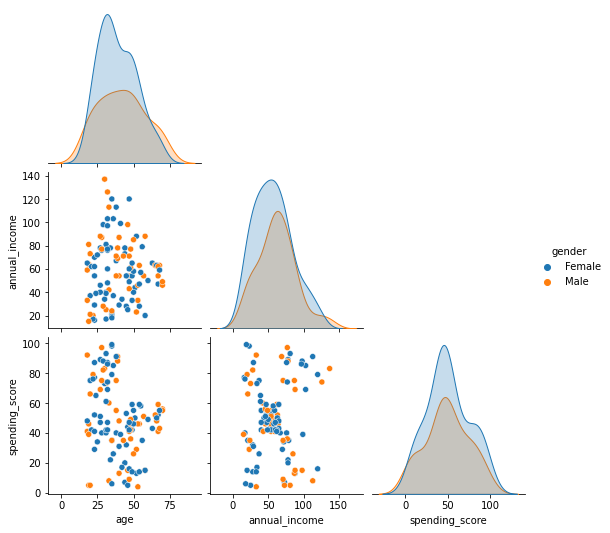

In [118]:
# print("Interaction of variables by gender")
sns.pairplot(train[['gender', 'age', 'annual_income', 'spending_score']], 
             corner=True,
             hue='gender'
            )
plt.show()

# plt.show()

## Conclusion



- we saw that age was important
- we might more time binning ages or making new feature surrounding ages (especially at 40)
- we saw gender doesnt have an impact 